# American Sign Language Classification with Deep Learning (Vision Transformers)

by Vinayak, Neel, Lax, Samarth

**Importing Dependencies**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
import os
import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

**Directory of Training Data**

In [4]:
train_dir = 'C:/Users/Vinay/Downloads/asl_alphabet_dataset/asl_alphabet_train/asl_alphabet_train/'

**Setting up GPU Environment**

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


**Loads and plots unique class labels**

unique_labels =  ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


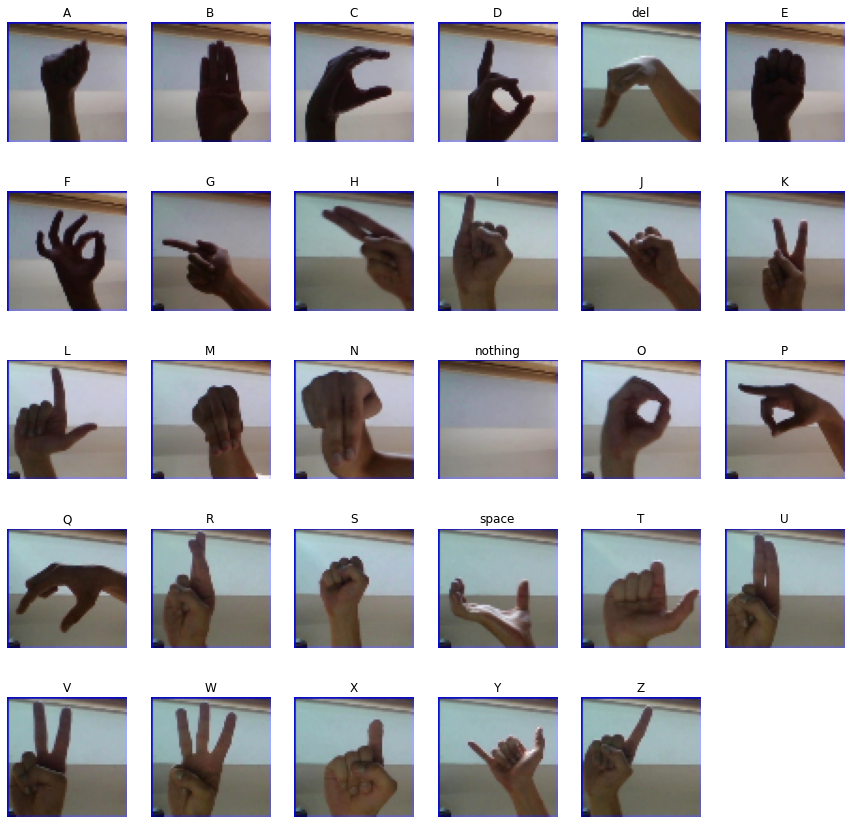

In [6]:
def load_unique():
    size_img = 64,64 
    images_plot = []
    labels_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            image = cv2.resize(image, size_img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images_plot.append(image)
            labels_plot.append(folder)
            break
    return images_plot, labels_plot

images_plot, labels_plot = load_unique()

fig = plt.figure(figsize = (15,15))
def plot_imgs(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_imgs(fig, images_plot[image_index], labels_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

**Loads Training Data**

In [7]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}


def load_train_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 32,32
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.np_utils.to_categorical(labels)
    
    x_train, y_train, x_test, y_test = train_test_split(images, labels, test_size = 0.1)

    #Reshaping output to include the class label
    y_test = np.nonzero(y_test)[1]
    y_train = np.nonzero(y_train)[1]


    print('Loaded', len(x_train),'images for training,','Train data shape =',x_train.shape)
    print('Loaded', len(x_test),'images for testing','Test data shape =',x_test.shape)
    
    return x_train, y_train, x_test, y_test

**Prints loaded data**

In [8]:
num_of_labels = 29
input_shape = (32, 32, 3)

x_train, y_train, x_test, y_test = load_train_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

LOADING DATA FROM : A | B | C | D | del | E | F | G | H | I | J | K | L | M | N | nothing | O | P | Q | R | S | space | T | U | V | W | X | Y | Z | Loaded 78300 images for training, Train data shape = (78300, 32, 32, 3)
Loaded 8700 images for testing Test data shape = (8700, 32, 32, 3)
x_train shape: (78300, 32, 32, 3) - y_train shape: (78300,)
x_test shape: (8700, 32, 32, 3) - y_test shape: (8700,)
[10 16 27 ... 16 20 20]
[24 19  9 ...  9 17  4]


**Data Augmentation**

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

**Multilayer Perceptron Implementation**

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Displays a random training sample**

(-0.5, 31.5, 31.5, -0.5)

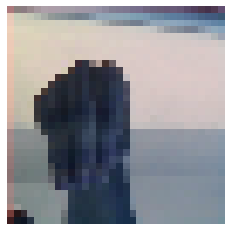

In [12]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

**Model Learning Parameters**

In [13]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_of_epochs = 1
image_size = 72  # Resizes input image to this
patch_size = 6  # Size of each patch of image
num_of_patches = (image_size // patch_size) ** 2
projection_dimension = 64
num_of_heads = 4

# Size of transformer layer
transformer_units = [
    projection_dimension * 2,
    projection_dimension,
]
transformer_layers = 8

# Size of the dense layers of the final classifier
mlp_head_units = [2048, 1024]

**Implements creation of image patches**

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Displays patches for a sample training image**

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


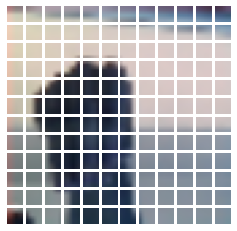

In [15]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

**Implements the patch encoding layer**

The patch encoding layer linearly transforms a patch into a vector of size projection_dimension. It also adds a position embedding to the projected vector.

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_of_patches, projection_dimension):
        super(PatchEncoder, self).__init__()
        self.num_of_patches = num_of_patches
        self.projection = layers.Dense(units=projection_dimension)
        self.position_embedding = layers.Embedding(
            input_dim=num_of_patches, output_dim=projection_dimension
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_of_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**Builds Vision Transformer model**

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_of_patches, projection_dimension)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_of_heads, key_dim=projection_dimension, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_of_labels)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

**Compiling, Training and Evaluating the Vision Transformer model**

In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
            
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_of_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model,history

#Builds the ViT model
vit_classifier = create_vit_classifier()

#Compiles, trains and evaluates the model
run_model = run_experiment(vit_classifier)

Epoch 1/30
2203/2203 [==============================] - 138s 59ms/step - loss: 2.6248 - accuracy: 0.2076 - top-5-accuracy: 0.5483 - val_loss: 1.5962 - val_accuracy: 0.4655 - val_top-5-accuracy: 0.8432
Epoch 2/30
2203/2203 [==============================] - 137s 62ms/step - loss: 1.4768 - accuracy: 0.5003 - top-5-accuracy: 0.8699 - val_loss: 0.7773 - val_accuracy: 0.7272 - val_top-5-accuracy: 0.9669
Epoch 3/30
2203/2203 [==============================] - 138s 63ms/step - loss: 0.9174 - accuracy: 0.6836 - top-5-accuracy: 0.9562 - val_loss: 0.4355 - val_accuracy: 0.8466 - val_top-5-accuracy: 0.9935
Epoch 4/30
2203/2203 [==============================] - 142s 64ms/step - loss: 0.6540 - accuracy: 0.7735 - top-5-accuracy: 0.9799 - val_loss: 0.2887 - val_accuracy: 0.8985 - val_top-5-accuracy: 0.9972
Epoch 5/30
2203/2203 [==============================] - 138s 63ms/step - loss: 0.5263 - accuracy: 0.8198 - top-5-accuracy: 0.9879 - val_loss: 0.2522 - val_accuracy: 0.9124 - val_top-5-accuracy: 0.

**Save Model Weights to disk and Check Model Summary**

In [45]:
run_model[0].save_weights("C:/Users/Vinay/Downloads/model.h5")
print("Saved model to disk")
print(run_model[0].summary())

Saved model to disk
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                          

 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 144, 128)     8320        ['layer_normalization_7[0][0]']  
          

                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 144, 64)     66368       ['layer_normalization_14[0][0]', 
 eadAttent

**Test the model and find accuracy**

In [32]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

run_model[0].compile(optimizer=optimizer,loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],)

results  = run_model[0].evaluate(x_test, y_test)


272/272 [==============================] - 6s 18ms/step - loss: 0.0486 - accuracy: 0.9844 - top-5-accuracy: 0.9999


**Get F1, Precision and Recall values**

In [43]:
from sklearn.metrics import classification_report

predictions = np.argmax(run_model[0].predict(x_test),axis=1)

print(classification_report(y_test, predictions, target_names = labels_for_plot))


              precision    recall  f1-score   support

           A       0.96      0.99      0.98       304
           B       0.99      0.96      0.98       293
           C       0.99      1.00      1.00       302
           D       0.99      0.99      0.99       324
         del       0.98      0.96      0.97       285
           E       1.00      0.92      0.96       306
           F       0.97      1.00      0.98       282
           G       0.99      0.98      0.98       279
           H       0.99      0.98      0.99       307
           I       1.00      0.99      0.99       288
           J       0.97      1.00      0.98       295
           K       0.99      1.00      1.00       306
           L       1.00      0.99      1.00       310
           M       0.99      1.00      0.99       324
           N       1.00      1.00      1.00       310
     nothing       0.99      0.99      0.99       282
           O       0.99      0.99      0.99       318
           P       0.97    

**Plot Training and Validation Loss and Accuracies**

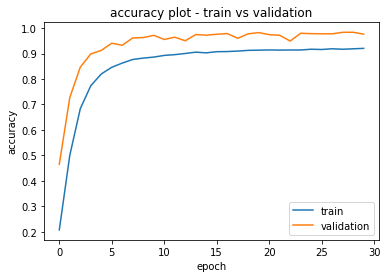

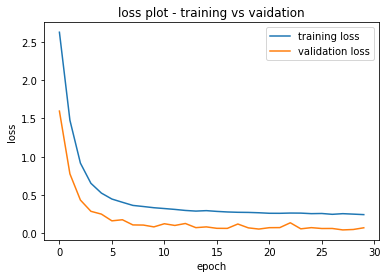

In [44]:
plt.plot(run_model[1].history['accuracy'])
plt.plot(run_model[1].history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('accuracy plot - train vs validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(run_model[1].history['loss'])
plt.plot(run_model[1].history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()